In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

CLEAN_PATH = "/home/yifan/dataset/resnet18_with_dropout/pairflip/cifar10/0/"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"


ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'

DEVICE='cuda:0'
########## initulize reference data and target data
from alignment.data_preprocess import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH)
tar_datainit = DataInit(CLEAN_PATH,CLEAN_PATH,TAR_EPOCH)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


from representationTrans.trans_visualizer_border import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 505.22it/s]


NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8199.17it/s]


absolute alignment indicates number: 106 label diff indicates number: 12 confidence diff indicates number: 16 high distance number: 97


In [2]:
from AlignVisAutoEncoder.autoencoder import SimpleAutoencoder
from AlignVisAutoEncoder.data import DataLoaderInit
input_dim = 512
output_dim = 512
hidden_dims = [512, 512, 512, 512, 512]
autoencoder = SimpleAutoencoder(512,512)

data_loader = DataLoaderInit(ref_train_data, tar_train_data)
dataloader = data_loader.get_data_loader()


In [4]:
import torch.optim as optim
import numpy as np
from pyemd import emd
import torch.nn as nn
from scipy.spatial.distance import cdist
from sklearn.neighbors import kneighbors_graph

# def earth_movers_distance(X, Y):
    
#     X, Y = X.detach().numpy(), Y.detach().numpy()
#     distance_matrix = cdist(X, Y)
#     first_histogram = np.ones(X.shape[0]) / X.shape[0]
#     second_histogram = np.ones(Y.shape[0]) / Y.shape[0]
#     return emd(first_histogram, second_histogram, distance_matrix)
def earth_movers_distance(X, Y, k=5):
    X, Y = X.detach().numpy(), Y.detach().numpy()
    
    # Compute KNN graphs
    X_knn_graph = kneighbors_graph(X, k, mode='distance')
    Y_knn_graph = kneighbors_graph(Y, k, mode='distance')
    
    # Convert to dense NumPy arrays
    X_knn_matrix = X_knn_graph.toarray()
    Y_knn_matrix = Y_knn_graph.toarray()

    # Calculate the EMD between the KNN distance matrices
    distance_matrix = cdist(X_knn_matrix, Y_knn_matrix)
    first_histogram = np.ones(X_knn_matrix.shape[0]) / X_knn_matrix.shape[0]
    second_histogram = np.ones(Y_knn_matrix.shape[0]) / Y_knn_matrix.shape[0]

    return emd(first_histogram, second_histogram, distance_matrix)

def frobenius_norm_loss(predicted, target):
    return torch.norm(predicted - target, p='fro') / predicted.numel()

# Define hyperparameters
num_epochs = 100
batch_size = 32
learning_rate = 1e-5

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate,weight_decay=1e-5)

alpha = 1 # weight for topological loss, adjust this according to your requirements

# Training loop
for epoch in range(num_epochs):
    for data_X, data_Y in dataloader: # Assuming you have a DataLoader instance with paired data (X, Y)
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass (encoding Y and decoding to X's space)
        transformed_Y = autoencoder.encoder(data_Y)
        recon_X = autoencoder.decoder(transformed_Y)

        # Calculate the loss
        # recon_loss = criterion(recon_X, data_X)

        # topological_loss = earth_movers_distance(data_Y, transformed_Y)

        # loss = recon_loss + alpha * topological_loss
        topological_loss_encoder = earth_movers_distance(data_Y, transformed_Y)
        topological_loss_decoder = earth_movers_distance(data_Y, recon_X)
        loss_f_decoder = frobenius_norm_loss(recon_X, data_Y) + topological_loss_decoder
        loss_f_encoder = frobenius_norm_loss(transformed_Y, data_X) + topological_loss_encoder

        loss = loss_f_decoder + loss_f_encoder 

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

    # Print the loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Loss decoder: {loss_f_decoder.item():.4f},Loss encoder: {loss_f_encoder.item():.4f},')


Epoch [1/100], Loss: 0.0106, Loss decoder: 0.0043,Loss encoder: 0.0063,
Epoch [2/100], Loss: 0.0084, Loss decoder: 0.0032,Loss encoder: 0.0052,
Epoch [3/100], Loss: 0.0087, Loss decoder: 0.0033,Loss encoder: 0.0054,
Epoch [4/100], Loss: 0.0083, Loss decoder: 0.0029,Loss encoder: 0.0054,
Epoch [5/100], Loss: 0.0084, Loss decoder: 0.0029,Loss encoder: 0.0055,
Epoch [6/100], Loss: 0.0079, Loss decoder: 0.0026,Loss encoder: 0.0053,
Epoch [7/100], Loss: 0.0080, Loss decoder: 0.0027,Loss encoder: 0.0053,
Epoch [8/100], Loss: 0.0080, Loss decoder: 0.0027,Loss encoder: 0.0052,
Epoch [9/100], Loss: 0.0078, Loss decoder: 0.0028,Loss encoder: 0.0051,
Epoch [10/100], Loss: 0.0079, Loss decoder: 0.0027,Loss encoder: 0.0052,
Epoch [11/100], Loss: 0.0079, Loss decoder: 0.0026,Loss encoder: 0.0052,
Epoch [12/100], Loss: 0.0077, Loss decoder: 0.0025,Loss encoder: 0.0052,
Epoch [13/100], Loss: 0.0079, Loss decoder: 0.0025,Loss encoder: 0.0054,
Epoch [14/100], Loss: 0.0073, Loss decoder: 0.0023,Loss enco

In [7]:
X = torch.Tensor(ref_train_data)
Y = torch.Tensor(tar_train_data)
# Transform X into Y's space
encoded_X = autoencoder.decoder(X)

# Transform Y into X's space
encoded_Y = autoencoder.encoder(Y)

In [16]:
##### eval

import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

from singleVis.eval.evaluate import *
n_neighbors = 30

train_data = encoded_Y.detach().numpy()
embedding = projector.batch_project(REF_EPOCH, train_data)
val = evaluate_proj_nn_perseverance_knn(train_data, embedding, n_neighbors=n_neighbors, metric="euclidean")

print("#train# nn preserving: {:.2f}/{:d} in epoch {:d}".format(val, n_neighbors, REF_EPOCH))


Sat Apr  8 00:49:42 2023 Building RP forest with 16 trees
Sat Apr  8 00:49:42 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Sat Apr  8 00:49:45 2023 Building RP forest with 16 trees
Sat Apr  8 00:49:45 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving: 2.57/30 in epoch 200


In [31]:

train_data = encoded_Y.detach().numpy()
embedding = projector.batch_project(REF_EPOCH, train_data)
inv_data = projector.batch_inverse(REF_EPOCH, embedding)
new_inv = autoencoder.decoder(torch.Tensor(inv_data))
new_inv = new_inv.detach().numpy()
pred = tar_provider.get_pred(REF_EPOCH, train_data).argmax(axis=1)
new_pred = tar_provider.get_pred(REF_EPOCH, new_inv).argmax(axis=1)

val = evaluate_inv_accu(pred, new_pred)
       
print("#train# PPR: {:.2f} in epoch {:d}".format(val, REF_EPOCH))
 

100%|██████████| 250/250 [00:00<00:00, 7851.74it/s]

#train# PPR: 0.33 in epoch 200


In [30]:

train_data = ref_train_data
embedding = projector.batch_project(REF_EPOCH, train_data)
inv_data = projector.batch_inverse(REF_EPOCH, embedding)

pred = tar_provider.get_pred(REF_EPOCH, train_data).argmax(axis=1)
new_pred = tar_provider.get_pred(REF_EPOCH, inv_data).argmax(axis=1)

val = evaluate_inv_accu(pred, new_pred)
       
print("#train# PPR: {:.2f} in epoch {:d}".format(val, REF_EPOCH))
 

100%|██████████| 250/250 [00:00<00:00, 7816.79it/s]

#train# PPR: 0.38 in epoch 200


In [17]:
##### eval

import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

from singleVis.eval.evaluate import *
n_neighbors = 30

train_data = ref_train_data
embedding = projector.batch_project(REF_EPOCH, train_data)
val = evaluate_proj_nn_perseverance_knn(train_data, embedding, n_neighbors=n_neighbors, metric="euclidean")

print("#train# nn preserving: {:.2f}/{:d} in epoch {:d}".format(val, n_neighbors, epoch))


Sat Apr  8 00:50:00 2023 Building RP forest with 16 trees
Sat Apr  8 00:50:01 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Sat Apr  8 00:50:04 2023 Building RP forest with 16 trees
Sat Apr  8 00:50:04 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving: 1.81/30 in epoch 99


Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 4888.49it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

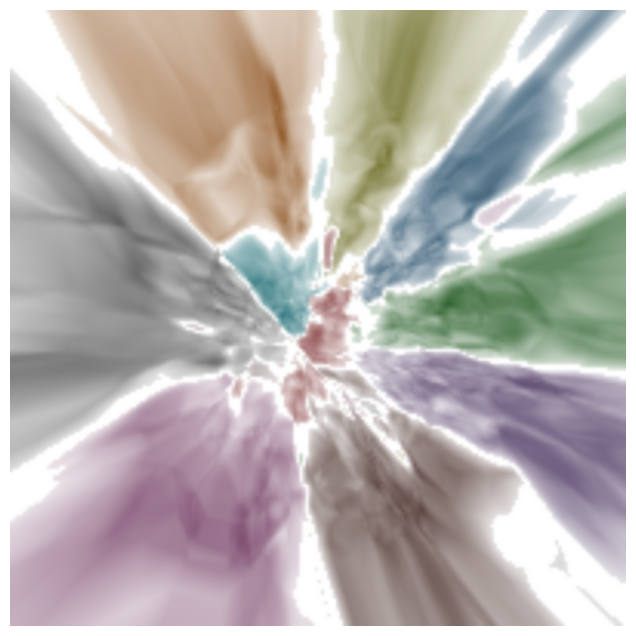

In [17]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_train_data, I), projector, 200,[[]],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 7814.06it/s]


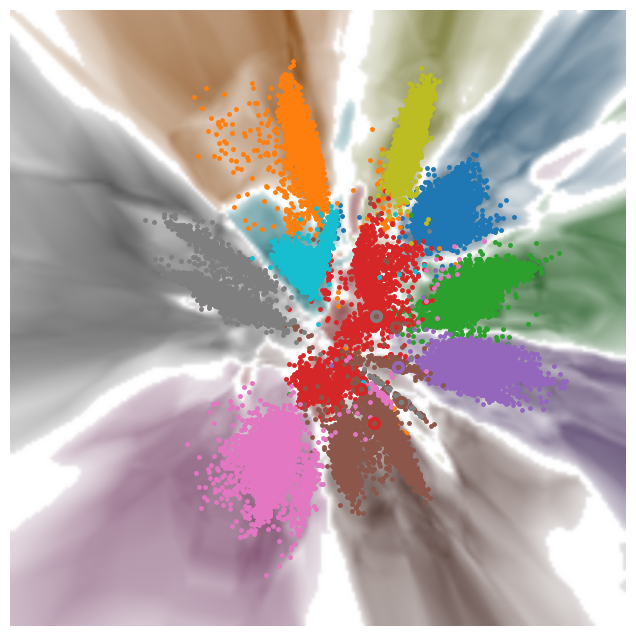

In [19]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from AlignVisAutoEncoder.trans_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, autoencoder,I,I, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 5674.73it/s]


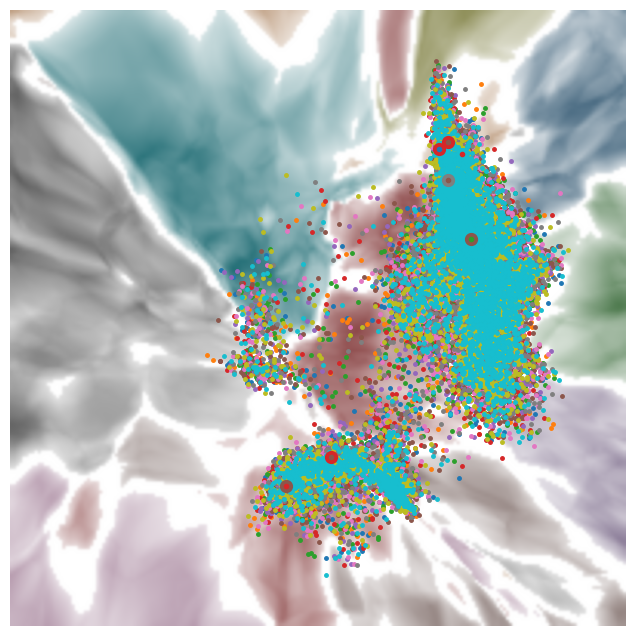

In [86]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 5441.52it/s]


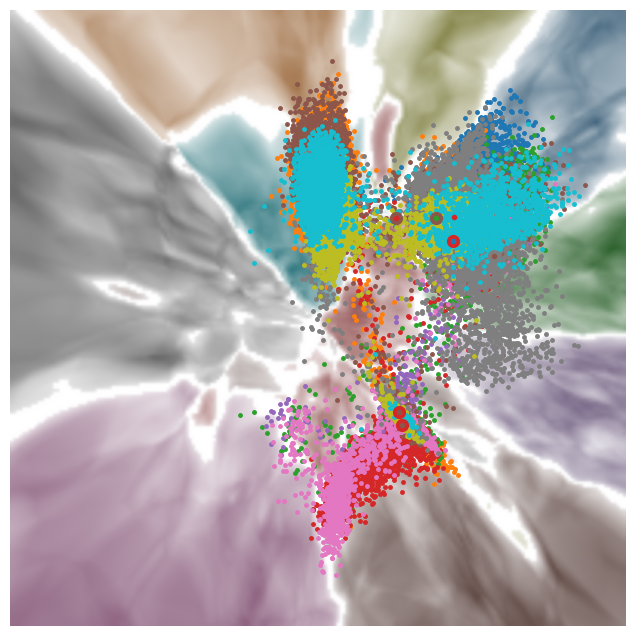

In [87]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(tar_train_data, I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))